# 1. Loading in the data
The profiles are stored in a .pickle file, where each row of the DataFrame is iteratively appended to the file one at a time. load_profiles_df loops through the .pickle file, appending each results from pkl.load() to the output DataFrame until there is no more data in the file.

In [1]:
import pandas as pd

import okctools

df_raw = okctools.load_profiles_df('profiles_old.pickle') # Defaults to 'profiles.pickle'

Loading file ...
Finished loading file.


In [2]:
df_raw.head()

,age,build,cats,city,diet,dogs,drinks,drugs,ed_prefix,education,...,monogamous,name,orientation,region,religion,religion_pre,sign,smokes,status,username
0,26,None,NaN,jakarta,NaN,NaN,NaN,NaN,NaN,NaN,...,None,ruth,[straight],indonesia,NaN,NaN,NaN,NaN,single,ruth2044624212
1,38,None,NaN,phoenix,omnivore,dogs,socially,None,attended,two-year college,...,None,shalena,[straight],az,agnostic,it’s important,aquarius,NaN,single,sheenerb20
2,30,None,NaN,beersheba,None,None,NaN,no,NaN,NaN,...,None,noa,[straight],israel,NaN,NaN,None,NaN,single,noache
3,24,None,NaN,crowley,NaN,NaN,NaN,NaN,NaN,NaN,...,None,mimi,[straight],tx,NaN,NaN,NaN,NaN,single,mimi9108466544
4,28,average,cats,parque industrial,vegetarian,dogs,socially,no,attended,university,...,None,mariane,[straight],brazil,None,None,cancer,no,single,marian1026462024


Here's a full list of parameter names:

In [3]:
df_raw.columns

Index(['age', 'build', 'cats', 'city', 'diet', 'dogs', 'drinks', 'drugs',
       'ed_prefix', 'education', 'essays', 'ethnicity', 'gender', 'height',
       'kids_future', 'kids_present', 'lang_primary', 'lang_secondary',
       'monogamous', 'name', 'orientation', 'region', 'religion',
       'religion_pre', 'sign', 'smokes', 'status', 'username'],
      dtype='object')

The 'kids_present' label is using 'present' as in 'now', but it would be easy to misinterpret it as 'existing'. Let's fix that with a quick rename.

In [4]:
df_raw.rename(columns={'kids_present': 'kids_current'}, inplace=True)

# 2. Null check

The data's looking pretty sparse. Let's find out just how sparse.

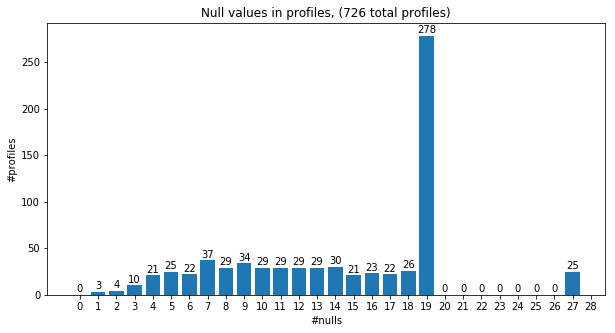

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
numcols = len(df_raw.columns)
nullcounts = list(map(lambda x: sum(df_raw.isnull().sum(axis=1) == x), 
                                range(numcols)))

plt.figure(figsize=(10,5));
plt.bar(range(numcols), nullcounts);
plt.xticks(range(numcols+1));
plt.title('Null values in profiles, (%s total profiles)' % len(df_raw));
plt.xlabel('#nulls');
plt.ylabel('#profiles');
for xpos, ypos in enumerate(nullcounts):
    plt.text(xpos, ypos + 3, str(ypos), ha='center')
plt.show()

A handful of profiles have only a non-null username field. This is because they turned up as "not found" on the OKC site. We have no way of knowing why (self-deletion/removal/etc.), but it's a surprisingly high percentage, given that the profile IDs were collected and then requested within the same day.

As far as I know, the second largest grouping is due to minimally-completed profiles.

So let's create subsets of the raw data:
- one with no empty profiles
- one with no empty or minimally-filled profiles

In [6]:
df_no_empty = df_raw[df_raw.isnull().sum(axis=1) != (numcols-1)].reset_index(drop=True)
df = df_no_empty[df_no_empty.isnull().sum(axis=1) != 19].reset_index(drop=True)

Now let's see how null each columns is.

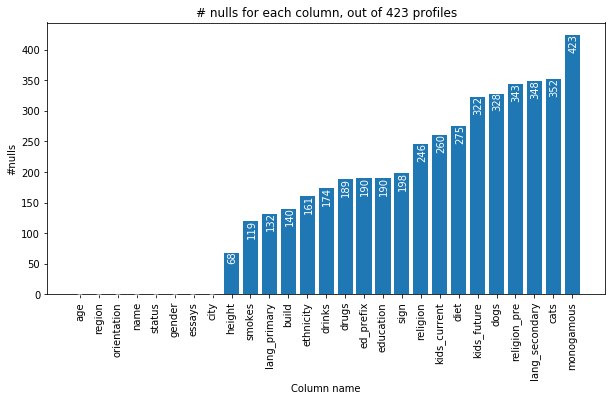

In [7]:
nullcols = df.isnull().sum(axis=0).sort_values()
nullcols = nullcols.drop('username')
fig2 = plt.figure(figsize=(10,5));
plt.bar(range(len(nullcols)), nullcols.values, width=.8)
for xpos, ypos in enumerate(nullcols.values):
    plt.text(xpos + .06, ypos + 3, str(ypos), 
             ha='center', va='top', rotation=90, color='white')
plt.xticks(range(len(nullcols)), nullcols.index, rotation=90)
plt.title('# nulls for each column, out of %s profiles' % len(df))
plt.xlabel('Column name')
plt.ylabel('#nulls')
plt.show()

Looks like there's a few interesting items, such as the unexpectedly high number of nulls in lang_primary.
Note that, for some parameters, there is only a 'yes' option, and the alternative is to not answer, as opposed to an explicit 'no' (e.g. for cats, dogs).

A unique parameter is 'essays', which is actually a list of dicts for each profile containing all of the free-response essay fields. Let's see how verbose things are around here.

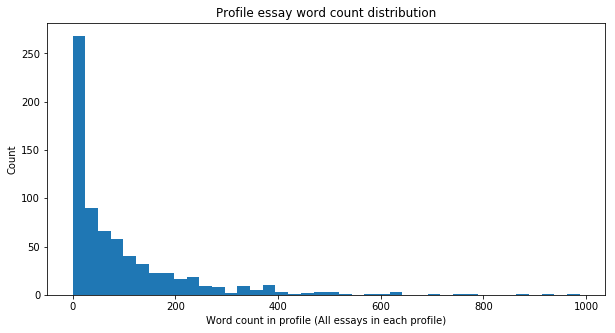

In [8]:
import numpy as np
import regex

def count_words(listofdicts):
    words = 0
    for essay in listofdicts:
        words += len(regex.findall(r'\b\w+\b', essay['content']))
    return words

wordcounts = np.fromiter(map(lambda essay: count_words(essay), df_no_empty.loc[:,'essays']), 'int32')

fig3 = plt.figure(figsize=(10,5));
plt.hist(wordcounts, bins=40)
plt.title('Profile essay word count distribution')
plt.xlabel('Word count in profile (All essays in each profile)')
plt.ylabel('Count')
plt.show()

There seems to be a pretty clear exponential tendancy to the word count distribution.

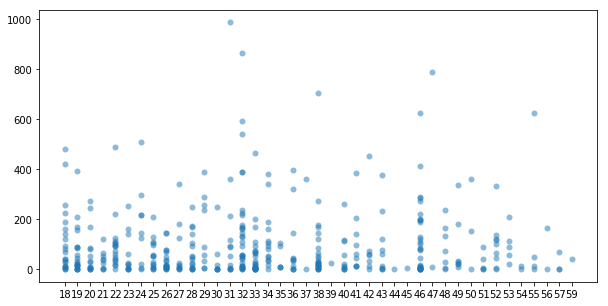

In [9]:
import numpy as np

age_index = np.argsort(df['age'].values)

fig4 = plt.figure(figsize=(10,5));
plt.plot(df.loc[age_index,'age'].values, wordcounts[age_index.tolist()], 'o', alpha=0.5, markeredgewidth=0.0)
plt.show()

In [10]:
df_no_empty.columns

Index(['age', 'build', 'cats', 'city', 'diet', 'dogs', 'drinks', 'drugs',
       'ed_prefix', 'education', 'essays', 'ethnicity', 'gender', 'height',
       'kids_future', 'kids_current', 'lang_primary', 'lang_secondary',
       'monogamous', 'name', 'orientation', 'region', 'religion',
       'religion_pre', 'sign', 'smokes', 'status', 'username'],
      dtype='object')

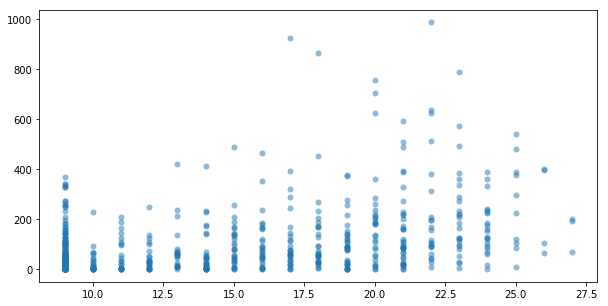

In [11]:

feature_counts = df_no_empty.notnull().sum(axis=1)
feature_count_index = np.argsort(feature_counts.values)
fig5 = plt.figure(figsize=(10,5));
plt.plot(feature_counts[feature_count_index].values, wordcounts[feature_count_index.tolist()], 'o', alpha=0.5, markeredgewidth=0.0)
plt.show()

In [12]:
#fig6 = plt.figure(figsize=(10,5));
#plt.hist(df_no_empty.age.values, bins=25)
#plt.show()